### 随机采样一致性

RANSAC(RANdom SAmple Consensus)，即随机采样一致性。RANSAC(RANdom SAmple Consensus)，即随机采样一致性。该方法最早是由Fischler和Bolles提出的一种鲁棒估计方法，最早用于计算机视觉中位姿估计问题，现在已广泛应用于已知模型的参数估计问题中。RANSAC算法被广泛应用在计算机视觉领域和数学领域，例如直线拟合、平面拟合、计算图像或点云间的变换矩阵、计算基础矩阵等方面，使用的非常多。

RANSAC算法对于数据中存在大比例外点（错误数据、野值点）时，RANSAC方法十分有效。

下面就以直线估计的例子来说明RANSAC的基本思想。

### 1、直线拟合-RANSAC估计基本原理

1） 随机选择两点(确定一条直线所需要的最小点集)，由这两个点确定一条线$l$:$y = ax + b$；

2） 根据阈值$t$，确定与直线$l$的几何距离小于$t$的数据点集$S(l)$，并称它为直线$l$的一致集；

3) 重复若干次随机选择，得到直线$l_{1},l_{2},\cdots l_{n}$和相应的一致集$S(l_{1}),S(l_{2}),\cdots S(l_{n})$；

4) 使用几何距离，求最大一致集的最佳拟合直线，作为数据点的最佳匹配直线。

如下图所示，首先在点集中随机选择两个点，求解它们构成的直线参数，再计算点集中剩余点到该直线的距离，距离小于设置的距离阈值的点为内点，统计内点个数；接下来再随机选取两个点，同样统计内点个数，以此类推；其中内点个数最多的点集即为最大一致集，最后将该最大一致集(如图d，点数最多)里面的点利用最小二乘拟合出一条直线。 

<img style="int:left; width:600px;" src="1.png" >

### 2、参数设置

根据上面RANSAC基本原理的介绍，在这算法流程中存在两个重要的参数需要设置：采样次数和距离阈值。

为了保证算法的效率，当数据量比较大时，我们不可能采集所有的样本，将所有的可能情况都计算一遍。如何在抽样当中保证至少有一个好样本（不包含外点）是我们需要考虑的问题。Fischler和Bolles在原文中通过概率统计的方法得出了采样次数与数据中外点比例和得到一个好样本概率之间的数学关系，在这里我直接给出结论，有兴趣推导该关系的博友可以自己阅读原文或者由吴福朝编写的《计算机视觉中的数学方法》。

1）采样次数

$K = \frac{\log (1 - z)}{\log (1 - w^n)}$

其中：<br>
$K$是需要采样的次数;<br>
$z$是获取一个好样本的概率，一般设置为99%;<br>
$w$是点集中内点的比例，一般可以在初始化时设置较小值，如0.1，然后更新迭代;<br>
$n$是模型参数估计需要的最小点数，直线拟合最少需要2个点。

2）距离阈值<br>
一般需要根据经验来设定

### RANSAC实现

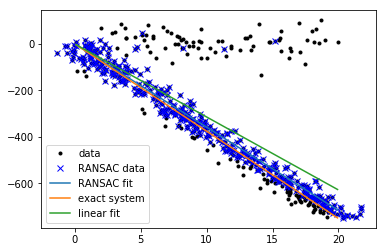

In [3]:
import numpy as np
import scipy as sp
import scipy.linalg as sl
 
def ransac(data, model, n, k, t, d, debug = False, return_all = False):
    """
    参考:http://scipy.github.io/old-wiki/pages/Cookbook/RANSAC
    伪代码:http://en.wikipedia.org/w/index.php?title=RANSAC&oldid=116358182
    输入:
        data - 样本点
        model - 假设模型:事先自己确定
        n - 生成模型所需的最少样本点
        k - 最大迭代次数
        t - 阈值:作为判断点满足模型的条件
        d - 拟合较好时,需要的样本点最少的个数,当做阈值看待
    输出:
        bestfit - 最优拟合解（返回nil,如果未找到）
    
    iterations = 0
    bestfit = nil #后面更新
    besterr = something really large #后期更新besterr = thiserr
    while iterations < k 
    {
        maybeinliers = 从样本中随机选取n个,不一定全是局内点,甚至全部为局外点
        maybemodel = n个maybeinliers 拟合出来的可能符合要求的模型
        alsoinliers = emptyset #满足误差要求的样本点,开始置空
        for (每一个不是maybeinliers的样本点)
        {
            if 满足maybemodel即error < t
                将点加入alsoinliers 
        }
        if (alsoinliers样本点数目 > d) 
        {
            %有了较好的模型,测试模型符合度
            bettermodel = 利用所有的maybeinliers 和 alsoinliers 重新生成更好的模型
            thiserr = 所有的maybeinliers 和 alsoinliers 样本点的误差度量
            if thiserr < besterr
            {
                bestfit = bettermodel
                besterr = thiserr
            }
        }
        iterations++
    }
    return bestfit
    """
    iterations = 0
    bestfit = None
    besterr = np.inf #设置默认值
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n, data.shape[0])
        maybe_inliers = data[maybe_idxs, :] #获取size(maybe_idxs)行数据(Xi,Yi)
        test_points = data[test_idxs] #若干行(Xi,Yi)数据点
        maybemodel = model.fit(maybe_inliers) #拟合模型
        test_err = model.get_error(test_points, maybemodel) #计算误差:平方和最小
        also_idxs = test_idxs[test_err < t]
        also_inliers = data[also_idxs,:]
        if debug:
            print ('test_err.min()',test_err.min())
            print ('test_err.max()',test_err.max())
            print ('numpy.mean(test_err)',numpy.mean(test_err))
            print ('iteration %d:len(alsoinliers) = %d' %(iterations, len(also_inliers)) )
        if len(also_inliers > d):
            betterdata = np.concatenate( (maybe_inliers, also_inliers) ) #样本连接
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(betterdata, bettermodel)
            thiserr = np.mean(better_errs) #平均误差作为新的误差
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate( (maybe_idxs, also_idxs) ) #更新局内点,将新点加入
        iterations += 1
        if bestfit is None:
            raise ValueError("did't meet fit acceptance criteria")
        if return_all:
            return bestfit,{'inliers':best_inlier_idxs}
        else:
            return bestfit
 
 
def random_partition(n, n_data):
    """return n random rows of data and the other len(data) - n rows"""
    all_idxs = np.arange(n_data) #获取n_data下标索引
    np.random.shuffle(all_idxs) #打乱下标索引
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2
 
class LinearLeastSquareModel:
    #最小二乘求线性解,用于RANSAC的输入模型    
    def __init__(self, input_columns, output_columns, debug = False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
    
    def fit(self, data):
        A = np.vstack( [data[:,i] for i in self.input_columns] ).T #第一列Xi-->行Xi
        B = np.vstack( [data[:,i] for i in self.output_columns] ).T #第二列Yi-->行Yi
        x, resids, rank, s = sl.lstsq(A, B) #residues:残差和
        return x #返回最小平方和向量   
 
    def get_error(self, data, model):
        A = np.vstack( [data[:,i] for i in self.input_columns] ).T #第一列Xi-->行Xi
        B = np.vstack( [data[:,i] for i in self.output_columns] ).T #第二列Yi-->行Yi
        B_fit = sp.dot(A, model) #计算的y值,B_fit = model.k*A + model.b
        err_per_point = np.sum( (B - B_fit) ** 2, axis = 1 ) #sum squared error per row
        return err_per_point
 
def test():
    #生成理想数据
    n_samples = 500 #样本个数
    n_inputs = 1 #输入变量个数
    n_outputs = 1 #输出变量个数
    A_exact = 20 * np.random.random((n_samples, n_inputs))#随机生成0-20之间的500个数据:行向量
    perfect_fit = 60 * np.random.normal( size = (n_inputs, n_outputs) ) #随机线性度即随机生成一个斜率
    B_exact = sp.dot(A_exact, perfect_fit) # y = x * k
 
    #加入高斯噪声,最小二乘能很好的处理
    A_noisy = A_exact + np.random.normal( size = A_exact.shape ) #500 * 1行向量,代表Xi
    B_noisy = B_exact + np.random.normal( size = B_exact.shape ) #500 * 1行向量,代表Yi
 
    if 1:
        #添加"局外点"
        n_outliers = 100
        all_idxs = np.arange( A_noisy.shape[0] ) #获取索引0-499
        np.random.shuffle(all_idxs) #将all_idxs打乱
        outlier_idxs = all_idxs[:n_outliers] #100个0-500的随机局外点
        A_noisy[outlier_idxs] = 20 * np.random.random( (n_outliers, n_inputs) ) #加入噪声和局外点的Xi
        B_noisy[outlier_idxs] = 50 * np.random.normal( size = (n_outliers, n_outputs)) #加入噪声和局外点的Yi
    #setup model 
    all_data = np.hstack( (A_noisy, B_noisy) ) #形式([Xi,Yi]....) shape:(500,2)500行2列
    input_columns = range(n_inputs)  #数组的第一列x:0
    output_columns = [n_inputs + i for i in range(n_outputs)] #数组最后一列y:1
    debug = False
    model = LinearLeastSquareModel(input_columns, output_columns, debug = debug) #类的实例化:用最小二乘生成已知模型
 
    linear_fit,resids,rank,s = sp.linalg.lstsq(all_data[:,input_columns], all_data[:,output_columns])
    
    #run RANSAC 算法
    ransac_fit, ransac_data = ransac(all_data, model, 50, 1000, 7e3, 300, debug = debug, return_all = True)
 
    if 1:
        import pylab
 
        sort_idxs = np.argsort(A_exact[:,0])
        A_col0_sorted = A_exact[sort_idxs] #秩为2的数组
 
        if 1:
            pylab.plot( A_noisy[:,0], B_noisy[:,0], 'k.', label = 'data' ) #散点图
            pylab.plot( A_noisy[ransac_data['inliers'], 0], B_noisy[ransac_data['inliers'], 0], 'bx', label = "RANSAC data" )
        else:
            pylab.plot( A_noisy[non_outlier_idxs,0], B_noisy[non_outlier_idxs,0], 'k.', label='noisy data' )
            pylab.plot( A_noisy[outlier_idxs,0], B_noisy[outlier_idxs,0], 'r.', label='outlier data' )
 
        pylab.plot( A_col0_sorted[:,0],
                    np.dot(A_col0_sorted,ransac_fit)[:,0],
                    label='RANSAC fit' )
        pylab.plot( A_col0_sorted[:,0],
                    np.dot(A_col0_sorted,perfect_fit)[:,0],
                    label='exact system' )
        pylab.plot( A_col0_sorted[:,0],
                    np.dot(A_col0_sorted,linear_fit)[:,0],
                    label='linear fit' )
        pylab.legend()
        pylab.show()
 
if __name__ == "__main__":
    test()